# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from scipy.signal import find_peaks

- The link where the data was downloaded is: http://insideairbnb.com/get-the-data/. 
- This dataset is specifically the listings in NYC. 
- The data columns can be explained when clicking on this link https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?usp=sharing. 
- Data used in this project was scraped on December 15, 2022.

# Loading and Preparing Datasets

In [3]:
# Dropping all of the columns which we will not use
listingsNYC = pd.read_csv('listings.csv', dtype=object)
# listingsNYC= listingsNYC.drop(['last_review','license','latitude','longitude','host_name'], axis=1)

# Dropping all rows with any 'Nan' values in them
# listingsNYC.dropna(axis=0, how='any', inplace=True)
data_types_dict = {
    'price':'int64', 
    'minimum_nights':'int64', 
    'host_id':str,
    'number_of_reviews':'int64',
    'reviews_per_month':float,
    'calculated_host_listings_count':'int64',
    'availability_365':'int64',
    'number_of_reviews_ltm':'int64'}

#changing all the datatype to their respective types that we can work with
listingsNYC = listingsNYC.astype(data_types_dict)

# creating a price per stay (ppn) column with the price and minimim nights columns and rounding to 2 decimal places. 
# This is a float dtype 
listingsNYC['pps'] = (listingsNYC['price'] * listingsNYC['minimum_nights']).round(2)
listingsNYC['neighbourhood'].unique().shape[0]
listingsNYC.describe()
listingsNYC['annual_revenue'] = (365 - listingsNYC['availability_365']) *  listingsNYC['price']
listingsNYC = listingsNYC[(listingsNYC['price'] != 0)]
listingsNYC.loc[:,'log_price']=np.log(listingsNYC['price'])
listingsNYC.loc[:,'log_pps']=np.log(listingsNYC['pps'])
listingsNYC.loc[:,'is_budget'] = listingsNYC['log_pps'].apply(lambda x: x < 6.69864257)
listingsNYC.loc[:,'is_luxury'] = listingsNYC['log_pps'].apply(lambda x: x > 6.69864257)
listingsNYC.describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,pps,annual_revenue,log_price,log_pps
count,41503.000000,41503.000000,41503.000000,32124.000000,41503.000000,41503.000000,41503.000000,4.150300e+04,4.150300e+04,41503.000000,41503.000000
mean,222.138737,18.599330,26.199431,1.278696,20.640797,143.391345,7.981471,3.316113e+03,4.432429e+04,4.938946,7.023476
std,919.815135,30.707935,56.166678,1.933835,68.897303,144.280187,18.560462,1.916982e+04,2.856041e+05,0.812185,1.485940
min,10.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000,1.900000e+01,0.000000e+00,2.302585,2.944439
25%,80.000000,2.000000,1.000000,0.140000,1.000000,0.000000,0.000000,3.500000e+02,8.030000e+03,4.382027,5.857933
50%,131.000000,10.000000,5.000000,0.580000,1.000000,87.000000,1.000000,1.341000e+03,2.555000e+04,4.875197,7.201171
75%,220.000000,30.000000,25.000000,1.880000,4.000000,312.000000,8.000000,3.600000e+03,4.999800e+04,5.393628,8.188689
max,98159.000000,1250.000000,1666.000000,102.980000,487.000000,365.000000,992.000000,2.253600e+06,3.129119e+07,11.494344,14.628039


### Removing Outliers

In [4]:
# check for outliers 
df = listingsNYC[(listingsNYC['price']<2000) & (listingsNYC['price']>20) & (listingsNYC['minimum_nights'] < 30)]
df.describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,pps,annual_revenue,log_price,log_pps
count,21690.000000,21690.000000,21690.000000,18659.000000,21690.000000,21690.000000,21690.000000,21690.000000,21690.000000,21690.000000,21690.000000
mean,221.639696,3.418442,38.833287,1.959596,8.148041,171.741263,14.499216,703.313324,40219.488751,5.079702,5.933164
std,229.568948,4.171019,69.240917,2.265433,25.637217,138.881675,23.650862,1200.655745,55265.613054,0.755109,1.068130
min,22.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000,28.000000,0.000000,3.091042,3.332205
25%,92.000000,1.000000,2.000000,0.560000,1.000000,32.000000,1.000000,175.000000,5867.500000,4.521789,5.164786
50%,150.000000,2.000000,13.000000,1.450000,2.000000,156.000000,7.000000,368.000000,25011.000000,5.010635,5.908083
75%,255.000000,4.000000,44.000000,2.820000,4.000000,333.000000,22.000000,750.000000,52045.500000,5.541264,6.620073
max,1999.000000,29.000000,1666.000000,102.980000,200.000000,365.000000,992.000000,31668.000000,729635.000000,7.600402,10.363062


### Dropping rows with a price or pps of 0

# Visualizations

array([ 885.44544824, 1168.1774783 , 1374.78934643, 1603.14983225,
       1733.64153843, 1864.13324461])

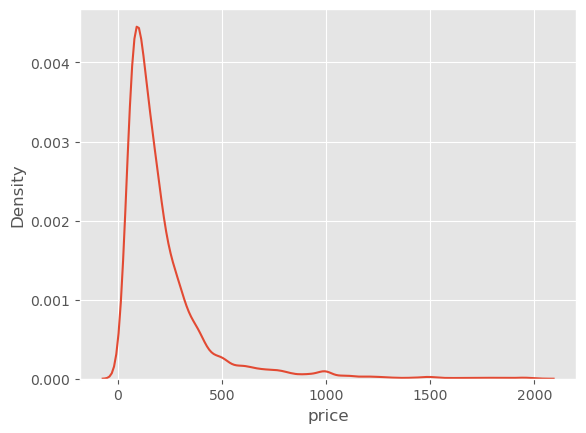

In [5]:
kde = sns.kdeplot(df['price'])

kde_values = -kde.get_lines()[0].get_ydata()
minima, _ = find_peaks(kde_values)

x_values = kde.get_lines()[0].get_xdata()[minima]
x_values

In [5]:
# add a dummy variable to 'classify' the listings into a 'luxury' and 'budget'
listingsNYC['is_budget'] = listingsNYC['log_pps'].apply(lambda x: x < 6.69864257)
listingsNYC['is_luxury'] = listingsNYC['log_pps'].apply(lambda x: x > 6.69864257)
listingsNYC

,id,name,host_id,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,pps,log_price,log_pps,is_budget,is_luxury
0,5136,"Spacious Brooklyn Duplex, Patio + Garden",7378,Brooklyn,Sunset Park,Entire home/apt,275,21,3,0.03,1,267,1,5775,5.616771,8.661294,False,True
1,5203,Cozy Clean Guest Room - Family Apt,7490,Manhattan,Upper West Side,Private room,75,2,118,0.73,1,0,0,150,4.317488,5.010635,True,False
2,5121,BlissArtsSpace!,7356,Brooklyn,Bedford-Stuyvesant,Private room,60,30,50,0.30,2,322,0,1800,4.094345,7.495542,False,True
3,5178,Large Furnished Room Near B'way,8967,Manhattan,Midtown,Private room,68,2,559,3.38,1,79,50,136,4.219508,4.912655,True,False
4,2595,Skylit Midtown Castle,2845,Manhattan,Midtown,Entire home/apt,175,30,49,0.31,3,365,1,5250,5.164786,8.565983,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41139,769580756557673403,Cozy 1 bedroom with 2 full beds ROOM #2,162927656,Queens,Jamaica,Shared room,99,1,1,1.00,7,174,1,99,4.595120,4.595120,True,False
41160,769612968972941927,Comfortable 1 bedroom ROOM #3,162927656,Queens,Jamaica,Shared room,91,1,1,1.00,7,174,1,91,4.510860,4.510860,True,False
41175,770593748958588679,Luxury Brooklyn apt. | 10 mins away from JFK,489532090,Brooklyn,East New York,Entire home/apt,145,1,2,2.00,1,351,2,145,4.976734,4.976734,True,False
41218,769850569510129629,Private Bed Manhattan 20 Mins,324722741,Queens,Woodside,Private room,50,1,1,1.00,1,240,1,50,3.912023,3.912023,True,False


In [9]:
listing_price_less_than_8k = listingsNYC.copy(deep=True)
listing_price_less_than_8k = listing_price_less_than_8k[listing_price_less_than_8k['price']<8000]
listing_price_less_than_8k.describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,pps,log_price,log_pps
count,32104.000000,32104.000000,32104.000000,32104.000000,32104.000000,32104.000000,32104.000000,32104.000000,32104.000000,32104.000000
mean,185.657332,16.144063,33.859613,1.279272,10.645247,142.585098,10.317188,2519.801458,4.907044,6.839624
std,234.270395,28.492633,61.794996,1.934261,38.342701,141.409811,20.524250,7826.297417,0.732834,1.455076
min,10.000000,1.000000,1.000000,0.010000,1.000000,0.000000,0.000000,19.000000,2.302585,2.944439
25%,80.000000,2.000000,3.000000,0.140000,1.000000,0.000000,0.000000,298.000000,4.382027,5.697093
50%,130.000000,5.000000,10.000000,0.580000,1.000000,89.000000,2.000000,1028.000000,4.867534,6.935370
75%,208.000000,30.000000,36.000000,1.880000,3.000000,306.000000,13.000000,3000.000000,5.337538,8.006368
max,7314.000000,1250.000000,1666.000000,102.980000,487.000000,365.000000,992.000000,724086.000000,8.897546,13.492665


In [18]:
brooklyn = listing_price_less_than_8k[listing_price_less_than_8k['neighbourhood_group']=='Brooklyn']
manhattan = listing_price_less_than_8k[listing_price_less_than_8k['neighbourhood_group']=='Manhattan']
queens = listing_price_less_than_8k[listing_price_less_than_8k['neighbourhood_group']=='Queens']
bronx = listing_price_less_than_8k[listing_price_less_than_8k['neighbourhood_group']=='Bronx']
staten_island = listing_price_less_than_8k[listing_price_less_than_8k['neighbourhood_group']=='Staten Island']
staten_island

,id,name,host_id,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,pps,log_price,log_pps,is_budget,is_luxury
80,42882,New York room with a view,185978,Staten Island,St. George,Private room,70,5,182,1.29,1,334,6,350,4.248495,5.857933,True,False
261,258838,"Oceanview,close to Manhattan",1360198,Staten Island,Arrochar,Entire home/apt,229,2,56,0.45,2,270,24,458,5.433722,6.126869,True,False
282,214917,New Clean Spacious Bed & Breakfast,1109658,Staten Island,Emerson Hill,Entire home/apt,76,30,2,0.03,1,0,0,2280,4.330733,7.731931,False,True
319,225976,Cozy multi-leveled apartment!,1177947,Staten Island,Shore Acres,Entire home/apt,80,4,91,0.67,1,190,3,320,4.382027,5.768321,True,False
475,503460,Spacious Apartment w extra room,2483236,Staten Island,New Springville,Private room,68,30,11,0.13,1,0,0,2040,4.219508,7.620705,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39302,744516984662773781,"Pool Table, Grill, Fireplace, TV, Huge Terrace",460459520,Staten Island,Todt Hill,Entire home/apt,348,1,2,2.00,1,345,2,348,5.852202,5.852202,True,False
39932,755866593147853163,Cozy Studio Apt On The Water/ Balcony skyline ...,427458930,Staten Island,Shore Acres,Entire home/apt,136,1,8,8.00,2,347,8,136,4.912655,4.912655,True,False
40056,756650222823891886,Lovely 3-bedrooms apartment Close to Ferry+NYC,121399223,Staten Island,St. George,Entire home/apt,230,3,1,1.00,7,153,1,690,5.438079,6.536692,True,False
40415,762529780175110037,RUMCH/Staten Island Hub,485490439,Staten Island,Tompkinsville,Entire home/apt,68,4,1,1.00,4,355,1,272,4.219508,5.605802,True,False


<AxesSubplot:xlabel='calculated_host_listings_count', ylabel='price'>

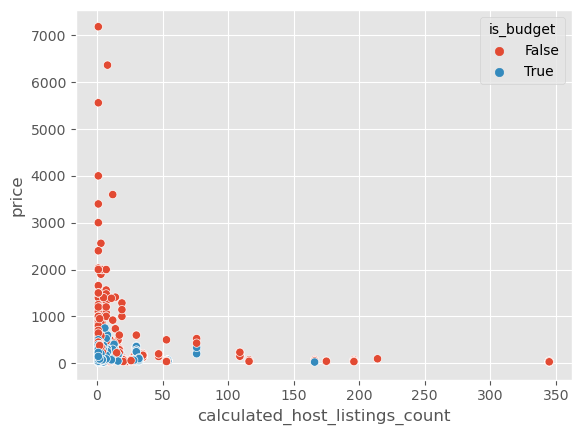

In [13]:
sns.scatterplot(x='calculated_host_listings_count',y='price',hue='is_budget', data=brooklyn)

<AxesSubplot:xlabel='calculated_host_listings_count', ylabel='price'>

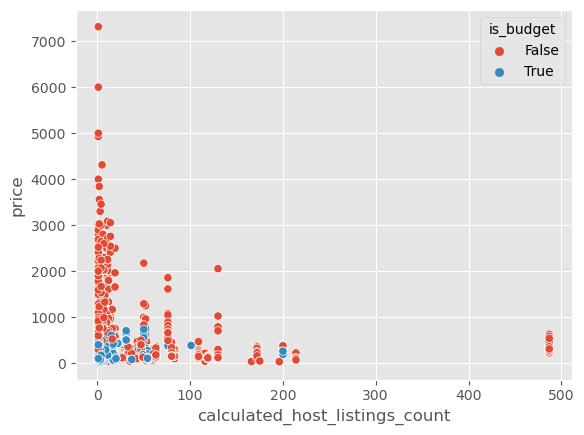

In [14]:
sns.scatterplot(x='calculated_host_listings_count',y='price',hue='is_budget', data=manhattan)

<AxesSubplot:xlabel='calculated_host_listings_count', ylabel='price'>

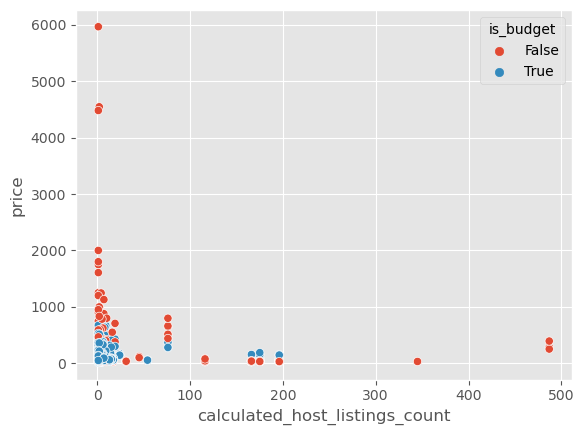

In [15]:
sns.scatterplot(x='calculated_host_listings_count',y='price',hue='is_budget', data=queens)

<AxesSubplot:xlabel='calculated_host_listings_count', ylabel='price'>

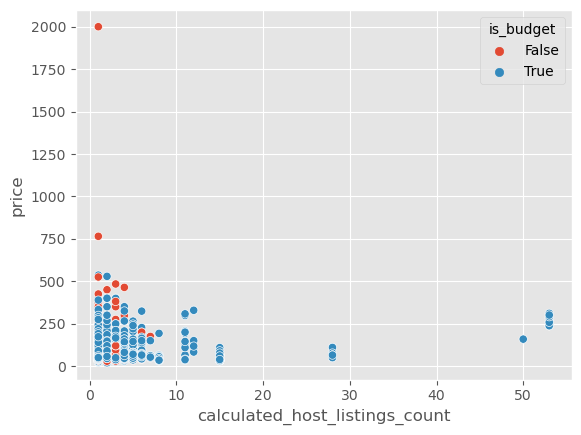

In [16]:
sns.scatterplot(x='calculated_host_listings_count',y='price',hue='is_budget', data=bronx)

<AxesSubplot:xlabel='calculated_host_listings_count', ylabel='price'>

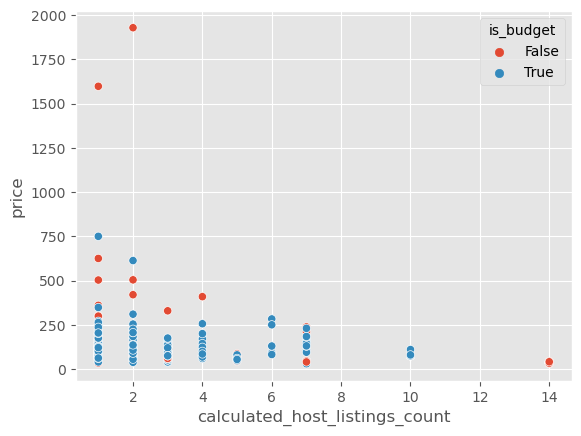

In [17]:
sns.scatterplot(x='calculated_host_listings_count',y='price',hue='is_budget', data=staten_island)